In [19]:
# Data
import yfinance as yf
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler

# Algorithms
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Model evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Time series
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

In [42]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)

# Load data

In [2]:
# Load data

# Amazon vs Microsoft, Google, IBM 
# Daily return past 10 years 
data = yf.download(tickers="AMZN MSFT GOOGL IBM", period='10y', interval='1d')

[*********************100%***********************]  4 of 4 completed


In [3]:
# Save stock data - Close price (adjusted) 

stk_data = data[['Adj Close']]
stk_data.columns = stk_data.columns.droplevel()

In [4]:
stk_data.index

DatetimeIndex(['2011-08-10', '2011-08-11', '2011-08-12', '2011-08-15',
               '2011-08-16', '2011-08-17', '2011-08-18', '2011-08-19',
               '2011-08-22', '2011-08-23',
               ...
               '2021-07-28', '2021-07-29', '2021-07-30', '2021-08-02',
               '2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06',
               '2021-08-09', '2021-08-10'],
              dtype='datetime64[ns]', name='Date', length=2517, freq=None)

In [5]:
# FX and market indices
# Trading dates may vary - will be adjusted

ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

ccy_data = web.DataReader(ccy_tickers, 'fred', start='2011-08-09', end='2021-08-09')
idx_data = web.DataReader(idx_tickers, 'fred', start='2011-08-09', end='2021-08-09')

For modeling, response (Y) and predictor (X) variables will be determined. Amazon stock pricing is the objective of this project. 

The data are represented with daily stock prices, but the response variable (Y) will be the weekly return of Amazon. The number of trading days a week will be assumed to be 5 days.

Independent variables (X) will include stock prices of correlated (likely) companies, market (foreign currency and indices) and lagged stock prices of Amazon. Returns will be rescaled using natural log. Logarithmic price scales tend to show less severe price increases or decreases than linear price scales - so it prevents small price changes being seen more trival than larger counterparts [reference](https://www.investopedia.com/terms/l/logarithmicscale.asp).


The major limitation of this pricing prediction model is that it only concerns correlated stocks and technical indicators, and leaving further investigations with other possible features used in fundamental analysis (i.e. performance reports, news). 



In [6]:
# Construct Y variable - AMZN stock price (5-day)

# To find correlations with other stocks, we need to get 5 day lagged price
# .diff() function produces 5-day returns after natural log rescaling
# .shift() function returns the stock prices that are 5 days later

periods = 5
Y = np.log(stk_data.loc[:, 'AMZN']).diff(periods).shift(-periods)
Y.name = Y.name + '_pred'

In [7]:
stk_data

,AMZN,GOOGL,IBM,MSFT
Date,,,,
2011-08-10,194.130005,274.779785,114.593414,19.391731
2011-08-11,198.360001,281.346344,117.547447,20.185030
2011-08-12,202.300003,282.167175,118.583801,20.112915
2011-08-15,202.949997,278.893890,121.960823,20.441450
2011-08-16,197.679993,269.769775,120.727028,20.441452
...,...,...,...,...
2021-08-04,3354.719971,2702.510010,141.135132,286.510010
2021-08-05,3375.989990,2725.030029,141.145035,289.519989
2021-08-06,3344.939941,2714.770020,142.449997,289.459991


In [8]:
# Construct X variables 

# 5-day returns for Correlated stocks - 'GOOGL', 'IBM', 'MSFT'
X1 = np.log(stk_data.loc[:, ('GOOGL', 'IBM', 'MSFT')]).diff(periods)

# 5-day returns for Foreign currency & Market indices
X2 = np.log(ccy_data).diff(periods)
X3 = np.log(idx_data).diff(periods)

# Lagged 5-day, 15-day, 30-day, 60-day AMZN returns 
X4 = [np.log(stk_data.loc[:, 'AMZN']).diff(i) for i in [periods, periods*3, periods*6,  periods*12]]
X4 = pd.concat(X4, axis=1)
X4.columns = ['AMZN_DT', 'AMZN_3DT', 'AMZN_6DT', 'AMZN_12DT']

In [9]:
# Combine all X variables

X = pd.concat([X1, X2, X3, X4], axis=1)

In [10]:
# Reconstruct dataset with X, Y variables
# Remove row records that contain at least one null values 
# It means that we only contains data corresponding to the dates of Y dataset

dataset = pd.concat([Y, X], axis=1).dropna()

In [11]:
# And also we are interested in seeing a weekly return
# So slicing with 5 day interval

dataset = dataset.iloc[::periods, :]

In [12]:
# Save the data

dataset.to_csv('StockData/PricingAMZN_Technical.csv')

# Descriptive analysis

In [13]:
dataset = pd.read_csv('StockData/PricingAMZN_Technical.csv', index_col=0, parse_dates=True)
dataset.head()

,AMZN_pred,GOOGL,IBM,MSFT,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AMZN_DT,AMZN_3DT,AMZN_6DT,AMZN_12DT
2011-11-03,-0.034962,-0.001956,0.007610,-0.026777,0.028098,-0.007616,-0.018416,-0.013531,0.180618,0.054169,-0.078643,-0.022378,0.117296
2011-11-10,-0.030197,-0.004058,-0.017303,-0.009468,-0.004886,-0.001505,-0.017163,-0.012589,0.073007,-0.034962,-0.102791,-0.053795,0.073105
2011-11-21,-0.004555,-0.053717,-0.031833,-0.060530,-0.000649,-0.015019,-0.048112,-0.045014,0.055605,-0.145683,-0.120615,-0.200733,-0.051592
2011-11-29,0.018929,0.003420,-0.002980,-0.006421,0.010198,-0.001343,0.006000,0.005372,-0.042492,-0.004555,-0.141383,-0.251786,-0.108593
2011-12-07,-0.080516,0.039260,0.031674,0.000782,0.001417,-0.000892,0.011204,0.012432,0.030815,0.015635,-0.109076,-0.150971,-0.116850


In [14]:
# Get Y, X variables
Y = dataset.loc[:, 'AMZN_pred'].copy()
X = dataset.drop(columns='AMZN_pred').copy()

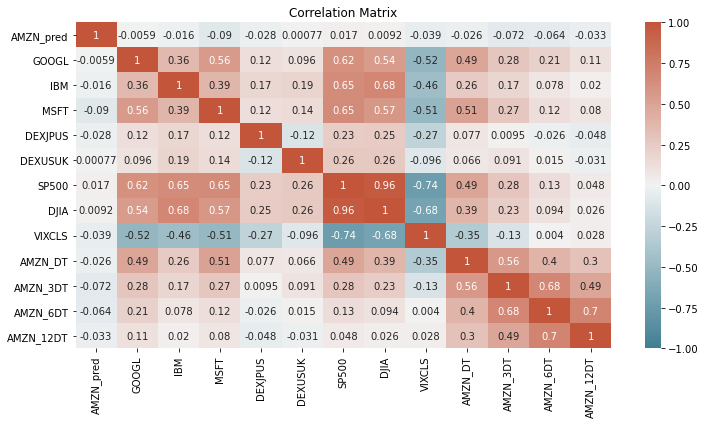

In [15]:
# Heatmap visualization

corr = dataset.corr()
plt.figure(figsize=(12,6))
plt.title('Correlation Matrix')
sns.heatmap(corr, annot=True, cbar=True, vmax=1, vmin=-1, cmap=sns.diverging_palette(220, 20, as_cmap=True)) # diverging
plt.show()

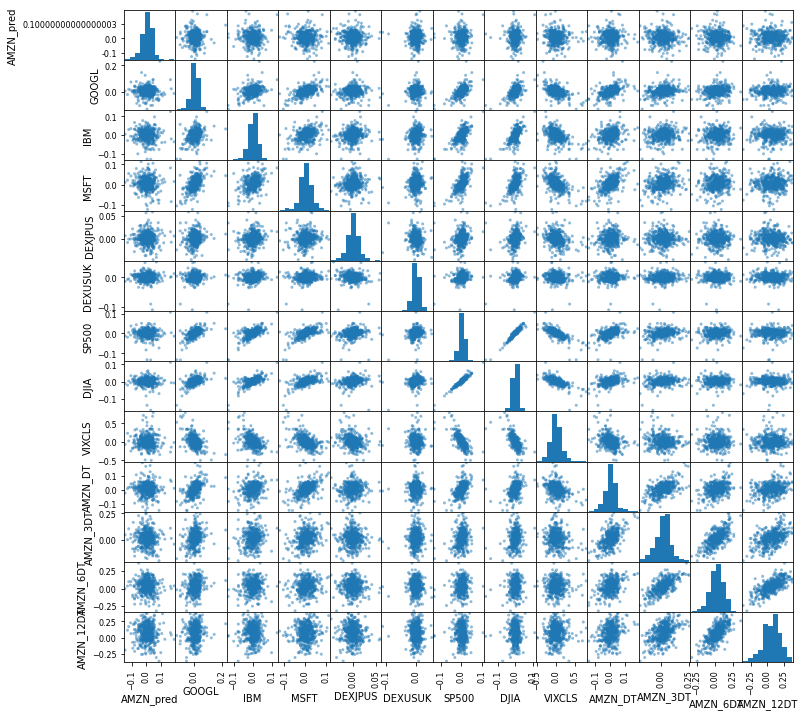

In [16]:
# Scatter plot visualization

scatter_matrix(dataset, figsize=(12,12))
plt.show()

No clear corrleation between AMZN ('AMZN_pred') and other stocks and markets. There are relatively strong negative correlation between VIXCLS and market indices and other stocks. Strong positive correlations are seen amongs lagged returns for Amazon. 

In [17]:
# Time series analysis

def tsa_seasonal_plot(r: pd.Series, period=52):
    model = sm.tsa.seasonal_decompose(r, period=period)
    fig= model.plot()
    fig.set_figheight(8)
    fig.set_figwidth(12)
    plt.show()

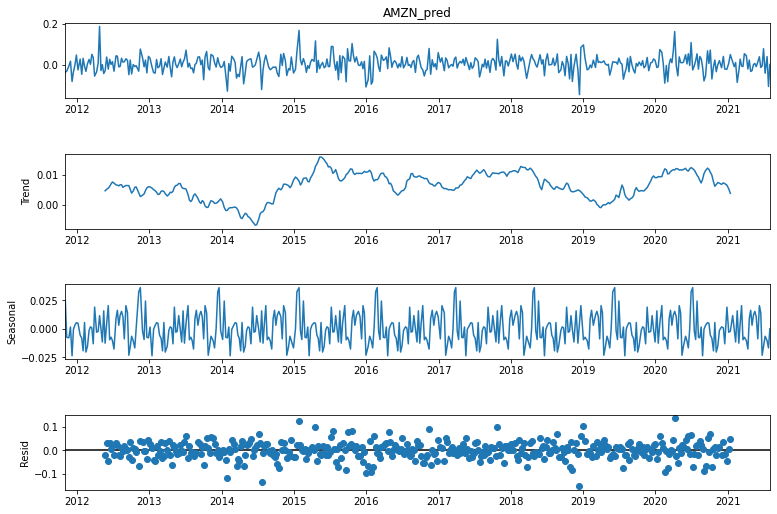

In [18]:
tsa_seasonal_plot(Y);

Amazon stocks have some trend fluctuations in returns. There has been an upward trend in the recent 2 years. The impact of Covid-19 (starting from early 2020) does not seem obvious to Amazon stock price.

# Modeling

It looks that additional data preparation is not necessary with clean and tidy dataset. Returns were log scaled so the additional preprocessing is not needed. Here, not many features are used so dimentional reduction may not be necessary.

In [21]:
# Regressors
# Using default parameters

models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('DT', DecisionTreeRegressor()),
    ('RFR', RandomForestRegressor()),
    ('GBR', GradientBoostingRegressor()),
    ('ABR', AdaBoostRegressor()),
    ('SVR', SVR())
]

In [24]:
dataset

,AMZN_pred,GOOGL,IBM,MSFT,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AMZN_DT,AMZN_3DT,AMZN_6DT,AMZN_12DT
2011-11-03,-0.034962,-0.001956,0.007610,-0.026777,0.028098,-0.007616,-0.018416,-0.013531,0.180618,0.054169,-0.078643,-0.022378,0.117296
2011-11-10,-0.030197,-0.004058,-0.017303,-0.009468,-0.004886,-0.001505,-0.017163,-0.012589,0.073007,-0.034962,-0.102791,-0.053795,0.073105
2011-11-21,-0.004555,-0.053717,-0.031833,-0.060530,-0.000649,-0.015019,-0.048112,-0.045014,0.055605,-0.145683,-0.120615,-0.200733,-0.051592
2011-11-29,0.018929,0.003420,-0.002980,-0.006421,0.010198,-0.001343,0.006000,0.005372,-0.042492,-0.004555,-0.141383,-0.251786,-0.108593
2011-12-07,-0.080516,0.039260,0.031674,0.000782,0.001417,-0.000892,0.011204,0.012432,0.030815,0.015635,-0.109076,-0.150971,-0.116850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,0.080120,-0.000453,0.009580,0.018243,0.005844,-0.009174,0.012450,0.012690,-0.031163,-0.004682,0.024570,0.060386,0.045768
2021-07-09,-0.039964,0.024795,-0.036902,0.023075,-0.009934,0.003401,0.003946,0.002406,0.071070,0.080120,0.063862,0.130238,0.109673
2021-07-19,0.041452,-0.019062,-0.021519,-0.001118,-0.008280,-0.014215,-0.029191,-0.029995,0.330358,-0.046502,0.042627,0.101739,0.070174
2021-07-26,-0.104868,0.073169,0.034561,0.042546,0.007827,0.010102,0.037745,0.034219,-0.246753,0.041452,0.052389,0.100271,0.063752


In [33]:
# Train, Test set
# As the dataset is time series,
# split sequentially  

validation_size = .2
split_point = int(dataset.shape[0] * (1-validation_size))
X_train, Y_train = X.iloc[:split_point], Y[:split_point]
X_test, Y_test = X.iloc[split_point:], Y.iloc[split_point:]

In [37]:
# Test for the best model
# Save K fold (10 folds) validation results for analysis
# Evaluate each model wih mean squaredd error

# Set up parameters for KFolds cv
num_folds = 10
scoring = 'neg_mean_squared_error'

names = []
kfold_results = [] # 10 folds cv
train_results = [] # mse
test_results = [] # mse

for name, model in models:
    names.append(name)
    ## Perform K fold test and save results
    kfold = KFold(n_splits=num_folds) 
    cv_results = -cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    ## Fit model and evaluate performances
    fitted = model.fit(X_train, Y_train)
    train_result = mean_squared_error(fitted.predict(X_train), Y_train)
    train_results.append(train_result)
    
    test_result = mean_squared_error(fitted.predict(X_test), Y_test)
    test_results.append(test_result)
    

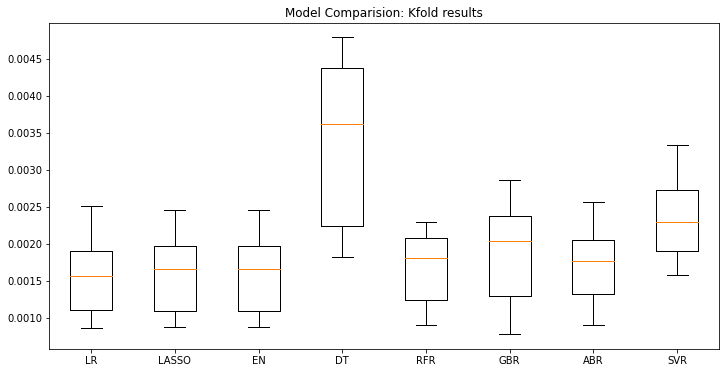

In [52]:
# Plotting the validation results

plt.boxplot(kfold_results)
plt.title('Model Comparision: Kfold results')
plt.xticks(ticks=np.arange(1, len(names)+1, 1), labels=names)
plt.show()

The boxplot shows a distribution of 10 discrete mean squared errors, resulted from kfold cross validations for each model/algorithm. Cross validation was performed on the training set only. So the higher the value, the worse the performance in general.

Linear models (**Linear Regression, LASSO, Elastic net**) performed comparatively better, whereas **ensemble models** are fairly okay. The good performance implies a good relationship between X and Y variable.

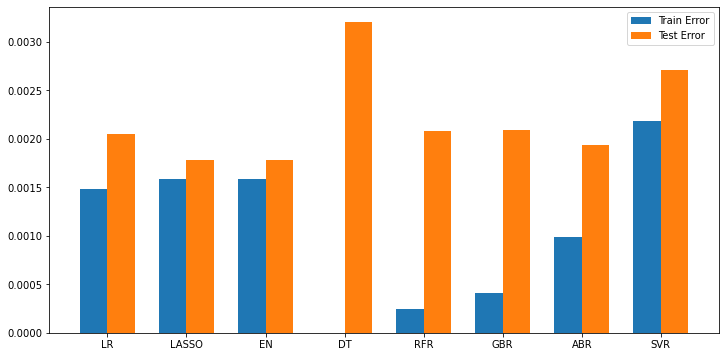

In [62]:
# Plotting the train and test errors

# A good tip to plot both errors in parallel 
loc = np.arange(len(names))
width = .35 

# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.bar(loc - width/2, train_results, width=width, label='Train Error')
plt.bar(loc + width/2, test_results, width=width, label='Test Error')

plt.xticks(ticks=loc, labels=names)
plt.legend(loc='best')
plt.show()

**Decision tree** shows a significant issue with overfitting. Ensemble models (**Random forecst, Gradient boost and Ada boost regressors**) also overfit the train data given high test errors compared to train errors. 

Linear models also appears slighly overfit. **Lasso** and **Elastic net** decrease the gaps between train and test errors possibly from regularization.  